# The Bias–Variance Tradeoff

In [60]:
knitr::opts_chunk$set(echo = TRUE, fig.align = "center", cache = TRUE, autodep = TRUE)

This chapter will begin to dig into some theoretical details of estimating regression functions, in particular how the **bias-variance tradeoff** helps explain the relationship between **model flexibility** and the errors a model makes.

Specifically, we will discuss:

- The definitions and relationship between **bias**, **variance**, and **mean squared error.**
- The relationship between **model flexibility** and training error.
- The relationship between **model flexibility** and validation error.

Don't fret if this presentation seems overwhelming. Next chapter we will review some general concepts about regression before moving on to classification.

## R Setup and Source

In [61]:
library(tibble)     # data frame printing
library(dplyr)      # data manipulation
library(caret)      # fitting knn
library(rpart)      # fitting trees
library(rpart.plot) # plotting trees

Recall that the [Welcome](index.html) chapter contains directions for installing all necessary packages for following along with the text. The R Markdown source is provided as some code, mostly for creating plots, has been suppressed from the rendered document that you are currently reading.

- **R Markdown Source:** [`bias-variance-tradeoff.Rmd`](bias-variance-tradeoff.Rmd)

## The Regression Setup

Consider the general regression setup where we are given a random pair $(X, Y) \in \mathbb{R}^p \times \mathbb{R}$. We would like to "predict" $Y$ with some function of $X$, say, $f(X)$.

To clarify what we mean by "predict," we specify that we would like $f(X)$ to be "close" to $Y$. To further clarify what we mean by "close," we define the **squared error loss** of estimating $Y$ using $f(X)$.

$$
L(Y, f(X)) \triangleq (Y - f(X)) ^ 2
$$

Now we can clarify the goal of regression, which is to minimize the above loss, on average. We call this the **risk** of estimating $Y$ using $f(X)$.

$$
R(Y, f(X)) \triangleq \mathbb{E}[L(Y, f(X))] = \mathbb{E}_{X, Y}[(Y - f(X)) ^ 2]
$$

Before attempting to minimize the risk, we first re-write the risk after conditioning on $X$.

$$
\mathbb{E}_{X, Y} \left[ (Y - f(X)) ^ 2 \right] = \mathbb{E}_{X} \mathbb{E}_{Y \mid X} \left[ ( Y - f(X) ) ^ 2 \mid X = x \right]
$$

Minimizing the right-hand side is much easier, as it simply amounts to minimizing the inner expectation with respect to $Y \mid X$, essentially minimizing the risk pointwise, for each $x$.

It turns out, that the risk is minimized by setting $f(x)$ to be equal the conditional mean of $Y$ given $X$,

$$
f(x) = \mathbb{E}(Y \mid X = x)
$$

which we call the **regression function**.^[Note that in this chapter, we will refer to $f(x)$ as the regression function instead of $\mu(x)$ for unimportant and arbitrary reasons.]

Note that the choice of squared error loss is somewhat arbitrary. Suppose instead we chose absolute error loss.

$$
L(Y, f(X)) \triangleq | Y - f(X) | 
$$

The risk would then be minimized setting $f(x)$ equal to the conditional median.

$$
f(x) = \text{median}(Y \mid X = x)
$$

Despite this possibility, our preference will still be for squared error loss. The reasons for this are numerous, including: historical, ease of optimization, and protecting against large deviations.

Now, given data $\mathcal{D} = (x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}$, our goal becomes finding some $\hat{f}$ that is a good estimate of the regression function $f$. We'll see that this amounts to minimizing what we call the reducible error.



## Reducible and Irreducible Error

Suppose that we obtain some $\hat{f}$, how well does it estimate $f$? We define the **expected prediction error** of predicting $Y$ using $\hat{f}(X)$. A good $\hat{f}$ will have a low expected prediction error. 

$$
\text{EPE}\left(Y, \hat{f}(X)\right) \triangleq \mathbb{E}_{X, Y, \mathcal{D}} \left[  \left( Y - \hat{f}(X) \right)^2 \right]
$$

This expectation is over $X$, $Y$, and also $\mathcal{D}$. The estimate $\hat{f}$ is actually random depending on the data, $\mathcal{D}$, used to estimate $\hat{f}$. We could actually write $\hat{f}(X, \mathcal{D})$ to make this dependence explicit, but our notation will become cumbersome enough as it is.

Like before, we'll condition on $X$. This results in the expected prediction error of predicting $Y$ using $\hat{f}(X)$ when $X = x$. 

$$
\text{EPE}\left(Y, \hat{f}(x)\right) = 
\mathbb{E}_{Y \mid X, \mathcal{D}} \left[  \left(Y - \hat{f}(X) \right)^2 \mid X = x \right] = 
\underbrace{\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right]}_\textrm{reducible error} + 
\underbrace{\mathbb{V}_{Y \mid X} \left[ Y \mid X = x \right]}_\textrm{irreducible error}
$$

A number of things to note here:

- The expected prediction error is for a random $Y$ given a fixed $x$ and a random $\hat{f}$. As such, the expectation is over $Y \mid X$ and $\mathcal{D}$. Our estimated function $\hat{f}$ is random depending on the data, $\mathcal{D}$, which is used to perform the estimation.
- The expected prediction error of predicting $Y$ using $\hat{f}(X)$ when $X = x$ has been decomposed into two errors:
    - The **reducible error**, which is the expected squared error loss of estimation $f(x)$ using $\hat{f}(x)$ at a fixed point $x$. The only thing that is random here is $\mathcal{D}$, the data used to obtain $\hat{f}$. (Both $f$ and $x$ are fixed.) We'll often call this reducible error the **mean squared error** of estimating $f(x)$ using $\hat{f}$ at a fixed point $x$. $$
\text{MSE}\left(f(x), \hat{f}(x)\right) \triangleq 
\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right]$$
    - The **irreducible error**. This is simply the variance of $Y$ given that $X = x$, essentially noise that we do not want to learn. This is also called the **Bayes error**.

As the name suggests, the reducible error is the error that we have some control over. But how do we control this error? 



## Bias-Variance Decomposition

After decomposing the expected prediction error into reducible and irreducible error, we can further decompose the reducible error.

Recall the definition of the **bias** of an estimator.

$$
\text{bias}(\hat{\theta}) \triangleq \mathbb{E}\left[\hat{\theta}\right] - \theta
$$

Also recall the definition of the **variance** of an estimator.

$$
\mathbb{V}(\hat{\theta}) = \text{var}(\hat{\theta}) \triangleq \mathbb{E}\left [ ( \hat{\theta} -\mathbb{E}\left[\hat{\theta}\right] )^2 \right]
$$

Using this, we further decompose the reducible error (mean squared error) into bias squared and variance.

$$
\text{MSE}\left(f(x), \hat{f}(x)\right) = 
\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right] = 
\underbrace{\left(f(x) - \mathbb{E} \left[ \hat{f}(x) \right]  \right)^2}_{\text{bias}^2 \left(\hat{f}(x) \right)} +
\underbrace{\mathbb{E} \left[ \left( \hat{f}(x) - \mathbb{E} \left[ \hat{f}(x) \right] \right)^2 \right]}_{\text{var} \left(\hat{f}(x) \right)}
$$

This is actually a common fact in estimation theory, but we have stated it here specifically for estimation of some regression function $f$ using $\hat{f}$ at some point $x$.

$$
\text{MSE}\left(f(x), \hat{f}(x)\right) = \text{bias}^2 \left(\hat{f}(x) \right) + \text{var} \left(\hat{f}(x) \right)
$$

In a perfect world, we would be able to find some $\hat{f}$ which is **unbiased**, that is $\text{bias}\left(\hat{f}(x) \right) = 0$, which also has low variance. In practice, this isn't always possible.

It turns out, there is a **bias-variance tradeoff**. That is, often, the more bias in our estimation, the lesser the variance. Similarly, less variance is often accompanied by more bias. Flexible models tend to be unbiased, but highly variable. Simple models are often extremely biased, but have low variance.

In the context of regression, models are biased when:

- Parametric: The form of the model [does not incorporate all the necessary variables](https://en.wikipedia.org/wiki/Omitted-variable_bias), or the form of the relationship is too simple. For example, a parametric model assumes a linear relationship, but the true relationship is quadratic.
- Non-parametric: The model provides too much smoothing.

In the context of regression, models are variable when:

- Parametric: The form of the model incorporates too many variables, or the form of the relationship is too flexible. For example, a parametric model assumes a cubic relationship, but the true relationship is linear.
- Non-parametric: The model does not provide enough smoothing. It is very, "wiggly."

So for us, to select a model that appropriately balances the tradeoff between bias and variance, and thus minimizes the reducible error, we need to select a model of the appropriate flexibility for the data.

Recall that when fitting models, we've seen that train RMSE decreases as model flexibility is increasing. (Technically it is non-increasing.) For validation RMSE, we expect to see a U-shaped curve. Importantly, validation RMSE decreases, until a certain flexibility, then begins to increase.

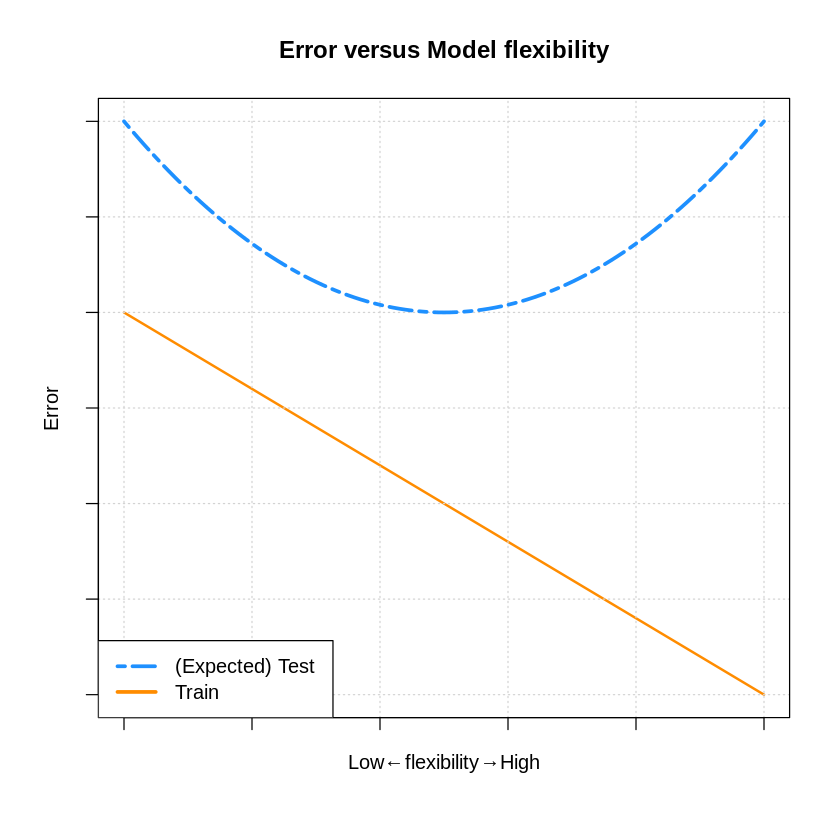

In [62]:
x = seq(0, 100, by = 0.001)
f = function(x) {
  ((x - 50) / 50) ^ 2 + 2
}
g = function(x) {
  1 - ((x - 50) / 50)
}
par(mgp = c(1.5, 1.5, 0)) 
plot(x, g(x), ylim = c(0, 3), type = "l", lwd = 2,
     ylab = "Error", xlab = expression(Low %<-% flexibility %->% High),
     main = "Error versus Model flexibility", col = "darkorange", 
     axes = FALSE)
grid()
axis(1, labels = FALSE)
axis(2, labels = FALSE)
box()
curve(f, lty = 6, col = "dodgerblue", lwd = 3, add = TRUE)
legend("bottomleft", c("(Expected) Test", "Train"), lty = c(6, 1), lwd = 3,
       col = c("dodgerblue", "darkorange"))

Now we can understand why this is happening. The expected test RMSE is essentially the expected prediction error, which we now known decomposes into (squared) bias, variance, and the irreducible Bayes error. The following plots show three examples of this.

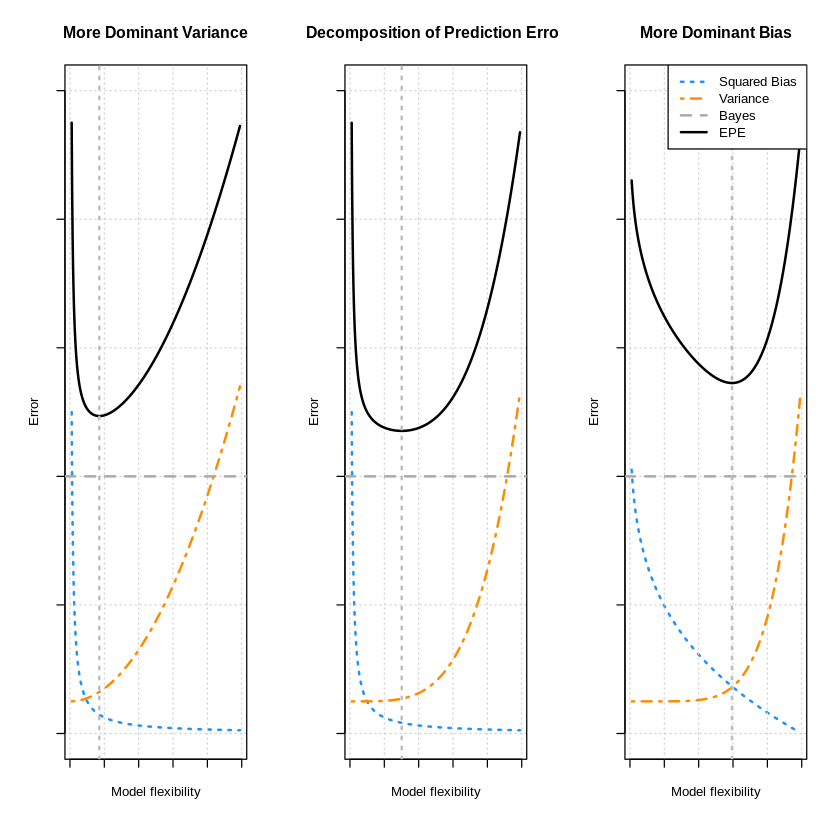

In [63]:
x = seq(0.01, 0.99, length.out = 1000)
par(mfrow = c(1, 3))
par(mgp = c(1.5, 1.5, 0))
b = 0.05 / x
v = 5 * x ^ 2 + 0.5
bayes = 4
epe = b + v + bayes
plot(x, b, type = "l", ylim = c(0, 10), col = "dodgerblue", lwd = 2, lty = 3,
     xlab = "Model flexibility", ylab = "Error", axes = FALSE,
     main = "More Dominant Variance")
axis(1, labels = FALSE)
axis(2, labels = FALSE)
grid()
box()
lines(x, v, col = "darkorange", lwd = 2, lty = 4)
lines(x, epe, col = "black", lwd = 2)
abline(h = bayes, lty = 2, lwd = 2, col = "darkgrey")
abline(v = x[which.min(epe)], col = "grey", lty = 3, lwd = 2)
b = 0.05 / x
v = 5 * x ^ 4 + 0.5
bayes = 4
epe = b + v + bayes
plot(x, b, type = "l", ylim = c(0, 10), col = "dodgerblue", lwd = 2, lty = 3,
     xlab = "Model flexibility", ylab = "Error", axes = FALSE,
     main = "Decomposition of Prediction Error")
axis(1, labels = FALSE)
axis(2, labels = FALSE)
grid()
box()
lines(x, v, col = "darkorange", lwd = 2, lty = 4)
lines(x, epe, col = "black", lwd = 2)
abline(h = bayes, lty = 2, lwd = 2, col = "darkgrey")
abline(v = x[which.min(epe)], col = "grey", lty = 3, lwd = 2)
b = 6 - 6 * x ^ (1 / 4)
v = 5 * x ^ 6 + 0.5
bayes = 4
epe = b + v + bayes
plot(x, b, type = "l", ylim = c(0, 10), col = "dodgerblue", lwd = 2, lty = 3,
     xlab = "Model flexibility", ylab = "Error", axes = FALSE,
     main = "More Dominant Bias")
axis(1, labels = FALSE)
axis(2, labels = FALSE)
grid()
box()
lines(x, v, col = "darkorange", lwd = 2, lty = 4)
lines(x, epe, col = "black", lwd = 2)
abline(h = bayes, lty = 2, lwd = 2, col = "darkgrey")
abline(v = x[which.min(epe)], col = "grey", lty = 3, lwd = 2)
legend("topright", c("Squared Bias", "Variance", "Bayes", "EPE"), lty = c(3, 4, 2, 1),
       col = c("dodgerblue", "darkorange", "darkgrey", "black"), lwd = 2)

The three plots show three examples of the bias-variance tradeoff. In the left panel, the variance influences the expected prediction error more than the bias. In the right panel, the opposite is true. The middle panel is somewhat neutral. In all cases, the difference between the Bayes error (the horizontal dashed grey line) and the expected prediction error (the solid black curve) is exactly the mean squared error, which is the sum of the squared bias (blue curve) and variance (orange curve). The vertical line indicates the flexibility that minimizes the prediction error.

To summarize, if we assume that irreducible error can be written as

$$
\mathbb{V}[Y \mid X = x] = \sigma ^ 2
$$

then we can write the full decomposition of the expected prediction error of predicting $Y$ using $\hat{f}$ when $X = x$ as

$$
\text{EPE}\left(Y, \hat{f}(x)\right) =  
\underbrace{\text{bias}^2\left(\hat{f}(x)\right) + \text{var}\left(\hat{f}(x)\right)}_\textrm{reducible error} + \sigma^2.
$$

As model flexibility increases, bias decreases, while variance increases. By understanding the tradeoff between bias and variance, we can manipulate model flexibility to find a model that will predict well on unseen observations.

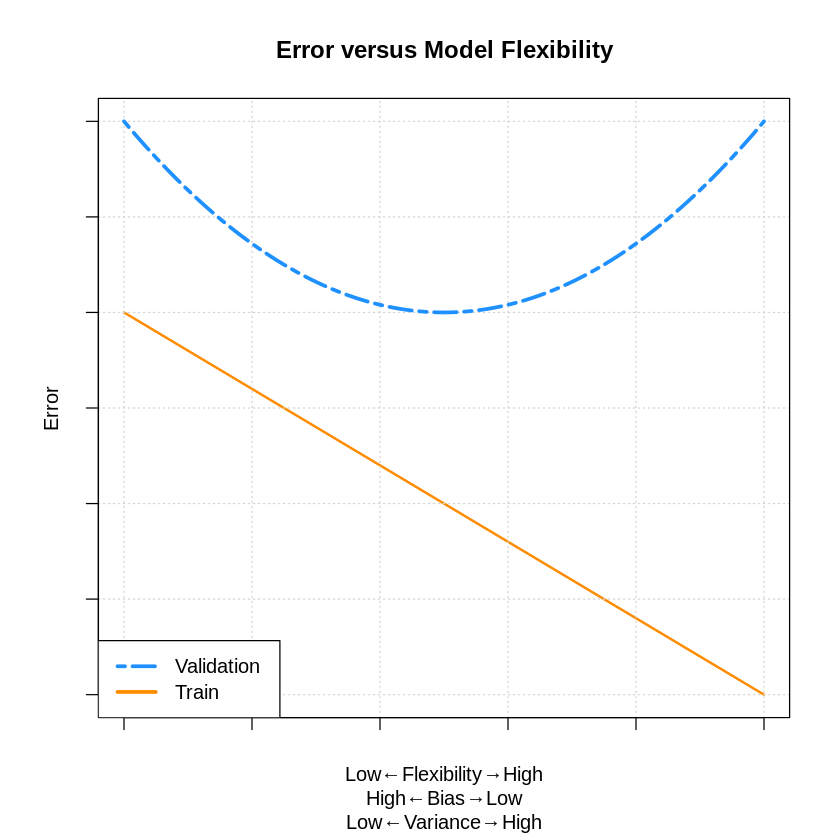

In [64]:
x = seq(0, 100, by = 0.001)
f = function(x) {
  ((x - 50) / 50) ^ 2 + 2
}
g = function(x) {
  1 - ((x - 50) / 50)
}
par(mgp = c(1.5, 1.5, 0)) 
plot(x, g(x), ylim = c(0, 3), type = "l", lwd = 2,
     ylab = "Error", xlab = "",
     main = "Error versus Model Flexibility", col = "darkorange", 
     axes = FALSE)
grid()
axis(1, labels = FALSE)
axis(2, labels = FALSE)
box()
ylabels = list(bquote("Low" %<-% "Flexibility" %->% "High"), 
               bquote("High" %<-% "Bias" %->% "Low"),
               bquote("Low" %<-% "Variance" %->% "High"))
mtext(do.call(expression, ylabels), side = 1, line = 2:4)
curve(f, lty = 6, col = "dodgerblue", lwd = 3, add = TRUE)
legend("bottomleft", c("Validation", "Train"), lty = c(6, 1), lwd = 3,
       col = c("dodgerblue", "darkorange"))

Tying this all together, the above image shows how we "expect" training and validation error to behavior in relation to model flexibility.^[Someday, someone will tell you this is a lie. They aren't wrong. In modern deep learning, there is a concept called [Deep Double Descent](https://openai.com/blog/deep-double-descent/). See also @belkin2018reconciling.] In practice, we won't always see such a nice "curve" in the validation error, but we expect to see the general trends.



## Using Simulation to Estimate Bias and Variance

We will illustrate these decompositions, most importantly the bias-variance tradeoff, through simulation. Suppose we would like to train a model to learn the true regression function function $f(x) = x^2$.

In [65]:
f = function(x) {
  x ^ 2
}

More specifically, we'd like to predict an observation, $Y$, given that $X = x$ by using $\hat{f}(x)$ where

$$
\mathbb{E}[Y \mid X = x] = f(x) = x^2
$$

and

$$
\mathbb{V}[Y \mid X = x] = \sigma ^ 2.
$$

Alternatively, we could write this as

$$
Y = f(X) + \epsilon
$$

where $\mathbb{E}[\epsilon] = 0$ and $\mathbb{V}[\epsilon] = \sigma ^ 2$. In this formulation, we call $f(X)$ the **signal** and $\epsilon$ the **noise**.

To carry out a concrete simulation example, we need to fully specify the data generating process. We do so with the following `R` code.

In [66]:
gen_sim_data = function(f, sample_size = 100) {
  x = runif(n = sample_size, min = 0, max = 1)
  y = rnorm(n = sample_size, mean = f(x), sd = 0.3)
  tibble(x, y)
}

Also note that if you prefer to think of this situation using the $Y = f(X) + \epsilon$ formulation, the following code represents the same data generating process.

In [67]:
gen_sim_data = function(f, sample_size = 100) {
  x = runif(n = sample_size, min = 0, max = 1)
  eps = rnorm(n = sample_size, mean = 0, sd = 0.75)
  y = f(x) + eps
  tibble(x, y)
}

To completely specify the data generating process, we have made more model assumptions than simply $\mathbb{E}[Y \mid X = x] = x^2$ and $\mathbb{V}[Y \mid X = x] = \sigma ^ 2$. In particular,

- The $x_i$ in $\mathcal{D}$ are sampled from a uniform distribution over $[0, 1]$.
- The $x_i$ and $\epsilon$ are independent.
- The $y_i$ in $\mathcal{D}$ are sampled from the conditional normal distribution.

$$
Y \mid X \sim N(f(x), \sigma^2)
$$

Using this setup, we will generate datasets, $\mathcal{D}$, with a sample size $n = 100$ and fit four models.

$$
\begin{aligned}
\texttt{predict(fit0, x)} &= \hat{f}_0(x) = \hat{\beta}_0\\
\texttt{predict(fit1, x)} &= \hat{f}_1(x) = \hat{\beta}_0 + \hat{\beta}_1 x \\
\texttt{predict(fit2, x)} &= \hat{f}_2(x) = \hat{\beta}_0 + \hat{\beta}_1 x + \hat{\beta}_2 x^2 \\
\texttt{predict(fit9, x)} &= \hat{f}_9(x) = \hat{\beta}_0 + \hat{\beta}_1 x + \hat{\beta}_2 x^2 + \ldots + \hat{\beta}_9 x^9
\end{aligned}
$$

To get a sense of the data and these four models, we generate one simulated dataset, and fit the four models.

In [68]:
set.seed(1)
sim_data = gen_sim_data(f)

In [69]:
fit_0 = lm(y ~ 1,                   data = sim_data)
fit_1 = lm(y ~ poly(x, degree = 1), data = sim_data)
fit_2 = lm(y ~ poly(x, degree = 2), data = sim_data)
fit_9 = lm(y ~ poly(x, degree = 9), data = sim_data)

Note that technically we're being lazy and using orthogonal polynomials, but the fitted values are the same, so this makes no difference for our purposes.

Plotting these four trained models, we see that the zero predictor model does very poorly. The first degree model is reasonable, but we can see that the second degree model fits much better. The ninth degree model seem rather wild.

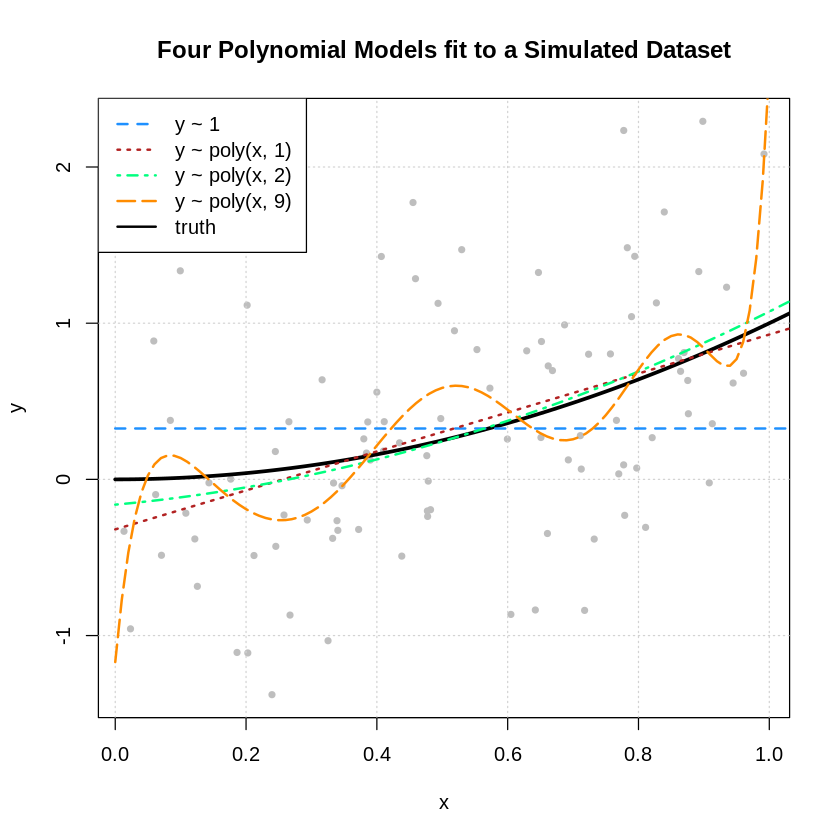

In [70]:
set.seed(42)
plot(y ~ x, data = sim_data, col = "grey", pch = 20,
     main = "Four Polynomial Models fit to a Simulated Dataset")
grid()
grid = seq(from = 0, to = 2, by = 0.01)
lines(grid, f(grid), col = "black", lwd = 3)
lines(grid, predict(fit_0, newdata = data.frame(x = grid)), col = "dodgerblue",  lwd = 2, lty = 2)
lines(grid, predict(fit_1, newdata = data.frame(x = grid)), col = "firebrick",   lwd = 2, lty = 3)
lines(grid, predict(fit_2, newdata = data.frame(x = grid)), col = "springgreen", lwd = 2, lty = 4)
lines(grid, predict(fit_9, newdata = data.frame(x = grid)), col = "darkorange",  lwd = 2, lty = 5)
legend("topleft", 
       c("y ~ 1", "y ~ poly(x, 1)", "y ~ poly(x, 2)",  "y ~ poly(x, 9)", "truth"), 
       col = c("dodgerblue", "firebrick", "springgreen", "darkorange", "black"), lty = c(2, 3, 4, 5, 1), lwd = 2)

The following three plots were created using three additional simulated datasets. The zero predictor and ninth degree polynomial were fit to each.

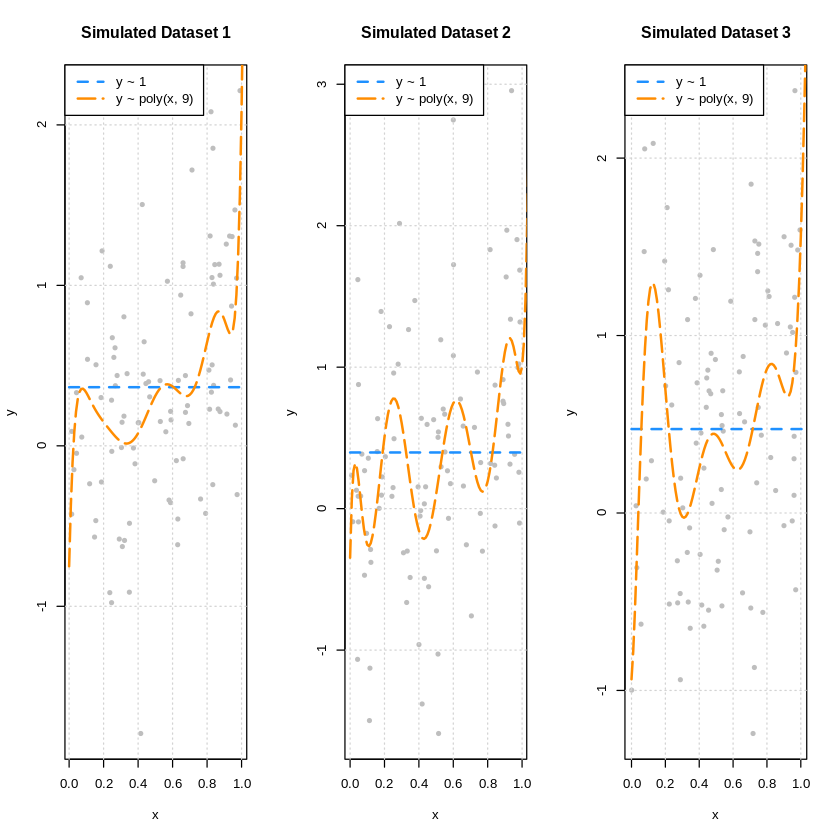

In [71]:
par(mfrow = c(1, 3))
# if you're reading this code
# it's BAD! don't use it. (or clean it up)
# also, note to self: clean up this code!!!
set.seed(430)
sim_data_1 = gen_sim_data(f)
sim_data_2 = gen_sim_data(f)
sim_data_3 = gen_sim_data(f)
fit_0_1 = lm(y ~ 1, data = sim_data_1)
fit_0_2 = lm(y ~ 1, data = sim_data_2)
fit_0_3 = lm(y ~ 1, data = sim_data_3)
fit_9_1 = lm(y ~ poly(x, degree = 9), data = sim_data_1)
fit_9_2 = lm(y ~ poly(x, degree = 9), data = sim_data_2)
fit_9_3 = lm(y ~ poly(x, degree = 9), data = sim_data_3)
plot(y ~ x, data = sim_data_1, col = "grey", pch = 20, main = "Simulated Dataset 1")
grid()
grid = seq(from = 0, to = 2, by = 0.01)
lines(grid, predict(fit_0_1, newdata = data.frame(x = grid)), col = "dodgerblue", lwd = 2, lty = 2)
lines(grid, predict(fit_9_1, newdata = data.frame(x = grid)), col = "darkorange", lwd = 2, lty = 5)
legend("topleft", c("y ~ 1", "y ~ poly(x, 9)"), col = c("dodgerblue", "darkorange"), lty = c(2, 5), lwd = 2)
plot(y ~ x, data = sim_data_2, col = "grey", pch = 20, main = "Simulated Dataset 2")
grid()
grid = seq(from = 0, to = 2, by = 0.01)
lines(grid, predict(fit_0_2, newdata = data.frame(x = grid)), col = "dodgerblue", lwd = 2, lty = 2)
lines(grid, predict(fit_9_2, newdata = data.frame(x = grid)), col = "darkorange", lwd = 2, lty = 5)
legend("topleft", c("y ~ 1", "y ~ poly(x, 9)"), col = c("dodgerblue", "darkorange"), lty = c(2, 5), lwd = 2)
plot(y ~ x, data = sim_data_3, col = "grey", pch = 20, main = "Simulated Dataset 3")
grid()
grid = seq(from = 0, to = 2, by = 0.01)
lines(grid, predict(fit_0_3, newdata = data.frame(x = grid)), col = "dodgerblue", lwd = 2, lty = 2)
lines(grid, predict(fit_9_3, newdata = data.frame(x = grid)), col = "darkorange", lwd = 2, lty = 5)
legend("topleft", c("y ~ 1", "y ~ poly(x, 9)"), col = c("dodgerblue", "darkorange"), lty = c(2, 5), lwd = 2)

This plot should make clear the difference between the bias and variance of these two models. The zero predictor model is clearly wrong, that is, biased, but nearly the same for each of the datasets, since it has very low variance.

While the ninth degree model doesn't appear to be correct for any of these three simulations, we'll see that on average it is, and thus is performing unbiased estimation. These plots do however clearly illustrate that the ninth degree polynomial is extremely variable. Each dataset results in a very different fitted model. Correct on average isn't the only goal we're after, since in practice, we'll only have a single dataset. This is why we'd also like our models to exhibit low variance.

We could have also fit $k$-nearest neighbors models to these three datasets.

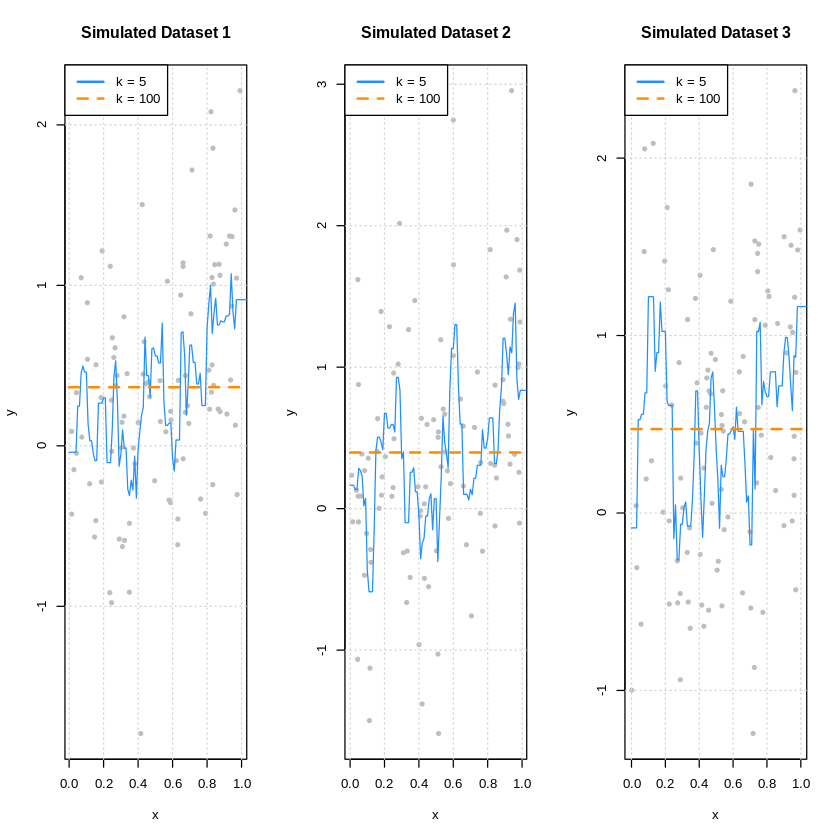

In [72]:
par(mfrow = c(1, 3))
# if you're reading this code
# it's BAD! don't use it. (or clean it up)
# also, note to self: clean up this code!!!
grid = seq(from = 0, to = 2, by = 0.01)
set.seed(430)
sim_data_1 = gen_sim_data(f)
sim_data_2 = gen_sim_data(f)
sim_data_3 = gen_sim_data(f)
fit_0_1 = predict(caret::knnreg(y ~ x, data = sim_data_1, k = 5), data.frame(x = grid))
fit_0_2 = predict(caret::knnreg(y ~ x, data = sim_data_2, k = 5), data.frame(x = grid))
fit_0_3 = predict(caret::knnreg(y ~ x, data = sim_data_3, k = 5), data.frame(x = grid))
fit_9_1 = predict(caret::knnreg(y ~ x, data = sim_data_1, k = 100), data.frame(x = grid))
fit_9_2 = predict(caret::knnreg(y ~ x, data = sim_data_2, k = 100), data.frame(x = grid))
fit_9_3 = predict(caret::knnreg(y ~ x, data = sim_data_3, k = 100), data.frame(x = grid))
plot(y ~ x, data = sim_data_1, col = "grey", pch = 20, main = "Simulated Dataset 1")
grid()
lines(grid, fit_0_1, col = "dodgerblue", lwd = 1, lty = 1)
lines(grid, fit_9_1, col = "darkorange", lwd = 2, lty = 2)
legend("topleft", c("k = 5", "k = 100"), col = c("dodgerblue", "darkorange"), lty = c(1, 2), lwd = 2)
plot(y ~ x, data = sim_data_2, col = "grey", pch = 20, main = "Simulated Dataset 2")
grid()
lines(grid, fit_0_2, col = "dodgerblue", lwd = 1, lty = 1)
lines(grid, fit_9_2, col = "darkorange", lwd = 2, lty = 2)
legend("topleft", c("k = 5", "k = 100"), col = c("dodgerblue", "darkorange"), lty = c(1, 2), lwd = 2)
plot(y ~ x, data = sim_data_3, col = "grey", pch = 20, main = "Simulated Dataset 3")
grid()
lines(grid, fit_0_3, col = "dodgerblue", lwd = 1, lty = 1)
lines(grid, fit_9_3, col = "darkorange", lwd = 2, lty = 2)
legend("topleft", c("k = 5", "k = 100"), col = c("dodgerblue", "darkorange"), lty = c(1, 2), lwd = 2)

Here we see that when $k = 100$ we have a biased model with very low variance.^[It's actually the same as the 0 predictor linear model. Can you see why?] When $k = 5$, we again have a highly variable model.

These two sets of plots reinforce our intuition about the bias-variance tradeoff. Flexible models (ninth degree polynomial and $k$ = 5) are highly variable, and often unbiased. Simple models (zero predictor linear model and $k = 100$) are very biased, but have extremely low variance.

We will now complete a simulation study to understand the relationship between the bias, variance, and mean squared error for the estimates of $f(x)$ given by these four models at the point $x = 0.90$. We use simulation to complete this task, as performing the analytical calculations would prove to be rather tedious and difficult.

In [73]:
set.seed(1)
n_sims = 250
n_models = 4
x = data.frame(x = 0.90) # fixed point at which we make predictions
predictions = matrix(0, nrow = n_sims, ncol = n_models)

In [74]:
for (sim in 1:n_sims) {
  # simulate new, random, training data
  # this is the only random portion of the bias, var, and mse calculations
  # this allows us to calculate the expectation over D
  sim_data = gen_sim_data(f)
  # fit models
  fit_0 = lm(y ~ 1,                   data = sim_data)
  fit_1 = lm(y ~ poly(x, degree = 1), data = sim_data)
  fit_2 = lm(y ~ poly(x, degree = 2), data = sim_data)
  fit_9 = lm(y ~ poly(x, degree = 9), data = sim_data)
  # get predictions
  predictions[sim, 1] = predict(fit_0, x)
  predictions[sim, 2] = predict(fit_1, x)
  predictions[sim, 3] = predict(fit_2, x)
  predictions[sim, 4] = predict(fit_9, x)
}

In [75]:
# # alternative simulation strategy
# sim_pred_from_lm_at_point = function(x) {
#   # x value to predict at
#   # coerce to data frame for predict() function
#   x = data.frame(x = x)
#   # simulate new training data
#   # expectation over D
#   sim_data = gen_sim_data(f)
#   # fit models
#   fit_0 = lm(y ~ 1,                   data = sim_data)
#   fit_1 = lm(y ~ poly(x, degree = 1), data = sim_data)
#   fit_2 = lm(y ~ poly(x, degree = 2), data = sim_data)
#   fit_9 = lm(y ~ poly(x, degree = 9), data = sim_data)
#   # get prediction at point for each model
#   c(predict(fit_0, x),
#     predict(fit_1, x),
#     predict(fit_2, x),
#     predict(fit_9, x))
# }
# set.seed(1)
# predictions = replicate(n = 250, sim_pred_from_lm_at_point(x = 0.90))

Note that this is one of many ways we could have accomplished this task using `R`. For example we could have used a combination of `replicate()` and `*apply()` functions. Alternatively, we could have used a [`tidyverse`](https://www.tidyverse.org/) approach, which likely would have used some combination of [`dplyr`](http://dplyr.tidyverse.org/), [`tidyr`](http://tidyr.tidyverse.org/), and [`purrr`](http://purrr.tidyverse.org/).

Our approach, which would be considered a `base` `R` approach, was chosen to make it as clear as possible what is being done. The `tidyverse` approach is rapidly gaining popularity in the `R` community, but might make it more difficult to see what is happening here, unless you are already familiar with that approach.

Also of note, while it may seem like the output stored in `predictions` would meet the definition of [tidy data](http://vita.had.co.nz/papers/tidy-data.html) given by [Hadley Wickham](http://hadley.nz/) since each row represents a simulation, it actually falls slightly short. For our data to be tidy, a row should store the simulation number, the model, and the resulting prediction. We've actually already aggregated one level above this. Our observational unit is a simulation (with four predictions), but for tidy data, it should be a single prediction.

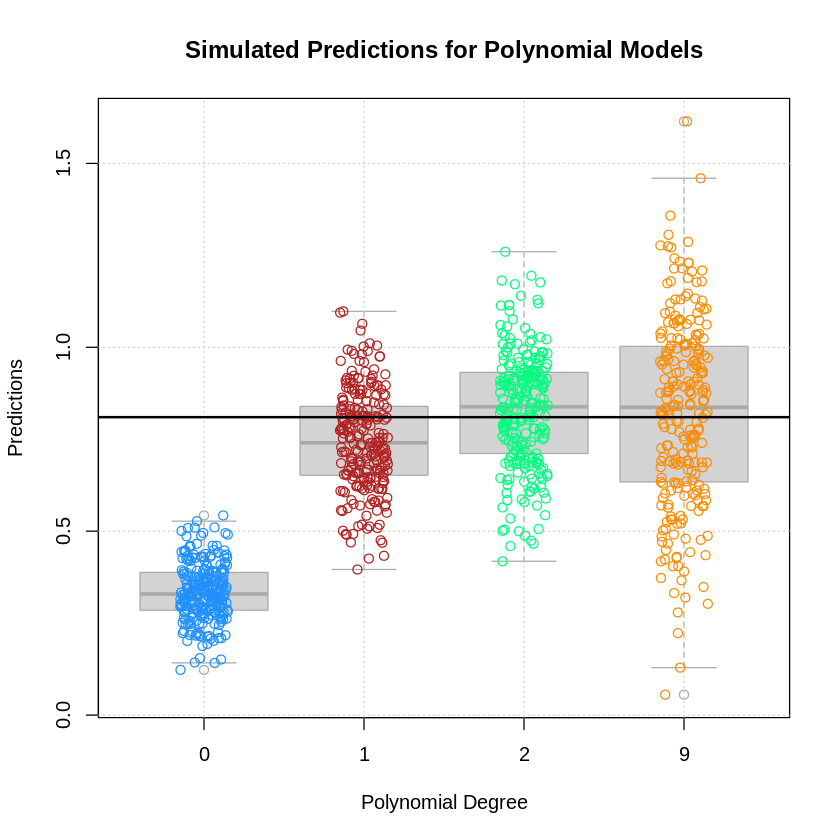

In [76]:
predictions = (predictions)
colnames(predictions) = c("0", "1", "2", "9")
predictions = as.data.frame(predictions)
tall_predictions = tidyr::gather(predictions, factor_key = TRUE)
boxplot(value ~ key, data = tall_predictions, border = "darkgrey", xlab = "Polynomial Degree", ylab = "Predictions",
        main = "Simulated Predictions for Polynomial Models")
grid()
stripchart(value ~ key, data = tall_predictions, add = TRUE, vertical = TRUE, method = "jitter", jitter = 0.15, pch = 1, col = c("dodgerblue", "firebrick", "springgreen", "darkorange"))
abline(h = f(x = 0.90), lwd = 2)

The above plot shows the predictions for each of the `r n_sims` simulations of each of the four models of different polynomial degrees. The truth, $f(x = 0.90) = (0.9)^2 = 0.81$, is given by the solid black horizontal line.

Two things are immediately clear:

- As flexibility *increases*, **bias decreases**. The mean of a model's predictions is closer to the truth.
- As flexibility *increases*, **variance increases**. The variance about the mean of a model's predictions increases.

The goal of this simulation study is to show that the following holds true for each of the four models.

$$
\text{MSE}\left(f(0.90), \hat{f}_k(0.90)\right) = 
\underbrace{\left(\mathbb{E} \left[ \hat{f}_k(0.90) \right] - f(0.90) \right)^2}_{\text{bias}^2 \left(\hat{f}_k(0.90) \right)} +
\underbrace{\mathbb{E} \left[ \left( \hat{f}_k(0.90) - \mathbb{E} \left[ \hat{f}_k(0.90) \right] \right)^2 \right]}_{\text{var} \left(\hat{f}_k(0.90) \right)}
$$

We'll use the empirical results of our simulations to estimate these quantities. (Yes, we're using estimation to justify facts about estimation.) Note that we've actually used a rather small number of simulations. In practice we should use more, but for the sake of computation time, we've performed just enough simulations to obtain the desired results. (Since we're estimating estimation, the bigger the sample size, the better.)

To estimate the mean squared error of our predictions, we'll use

$$
\widehat{\text{MSE}}\left(f(0.90), \hat{f}_k(0.90)\right) = \frac{1}{n_{\texttt{sims}}}\sum_{i = 1}^{n_{\texttt{sims}}} \left(f(0.90) - \hat{f}_k^{[i]}(0.90) \right)^2
$$

where $\hat{f}_k^{[i]}(0.90)$ is the estimate of $f(0.90)$ using the $i$-th from the polynomial degree $k$ model.

We also write an accompanying `R` function.

In [77]:
get_mse = function(truth, estimate) {
  mean((estimate - truth) ^ 2)
}

Similarly, for the bias of our predictions we use,

$$
\widehat{\text{bias}} \left(\hat{f}(0.90) \right)  = \frac{1}{n_{\texttt{sims}}}\sum_{i = 1}^{n_{\texttt{sims}}} \left(\hat{f}_k^{[i]}(0.90) \right) - f(0.90)
$$

And again, we write an accompanying `R` function.

In [78]:
get_bias = function(estimate, truth) {
  mean(estimate) - truth
}

Lastly, for the variance of our predictions we have

$$
\widehat{\text{var}} \left(\hat{f}(0.90) \right) = \frac{1}{n_{\texttt{sims}}}\sum_{i = 1}^{n_{\texttt{sims}}} \left(\hat{f}_k^{[i]}(0.90) - \frac{1}{n_{\texttt{sims}}}\sum_{i = 1}^{n_{\texttt{sims}}}\hat{f}_k^{[i]}(0.90) \right)^2 
$$

While there is already `R` function for variance, the following is more appropriate in this situation.

In [79]:
get_var = function(estimate) {
  mean((estimate - mean(estimate)) ^ 2)
}

To quickly obtain these results for each of the four models, we utilize the `apply()` function.

In [80]:
bias = apply(predictions, 2, get_bias, truth = f(x = 0.90))
variance = apply(predictions, 2, get_var)
mse = apply(predictions, 2, get_mse, truth = f(x = 0.90))

We summarize these results in the following table.

In [81]:
results = data.frame(
  poly_degree = c(0, 1, 2, 9),
  round(mse, 5),
  round(bias ^ 2, 5),
  round(variance, 5)
)
colnames(results) = c("Degree", "Mean Squared Error", "Bias Squared", "Variance")
rownames(results) = NULL
knitr::kable(results, booktabs = TRUE, escape = TRUE, align = "c")



| Degree | Mean Squared Error | Bias Squared | Variance |
|:------:|:------------------:|:------------:|:--------:|
|   0    |      0.23094       |   0.22492    | 0.00601  |
|   1    |      0.02249       |   0.00411    | 0.01838  |
|   2    |      0.02418       |   0.00033    | 0.02384  |
|   9    |      0.06371       |   0.00013    | 0.06358  |

A number of things to notice here:

- We use squared bias in this table. Since bias can be positive or negative, squared bias is more useful for observing the trend as flexibility increases. 
- The squared bias trend which we see here is **decreasing** as flexibility increases, which we expect to see in general.
- The exact opposite is true of variance. As model flexibility increases, variance **increases**.
- The mean squared error, which is a function of the bias and variance, decreases, then increases. This is a result of the bias-variance tradeoff. We can decrease bias, by increasing variance. Or, we can decrease variance by increasing bias. By striking the correct balance, we can find a good mean squared error!

We can check for these trends with the `diff()` function in `R`.

In [82]:
all(diff(bias ^ 2) < 0)
all(diff(variance) > 0)
diff(mse) < 0 

[1] TRUE

[1] TRUE

1     2     9 
 TRUE FALSE FALSE

The models with polynomial degrees 2 and 9 are both essentially unbiased. We see some bias here as a result of using simulation. If we increased the number of simulations, we would see both biases go down. Since they are both unbiased, the model with degree 2 outperforms the model with degree 9 due to its smaller variance.

Models with degree 0 and 1 are biased because they assume the wrong form of the regression function. While the degree 9 model does this as well, it does include all the necessary polynomial degrees. 

$$
\hat{f}_9(x) = \hat{\beta}_0 + \hat{\beta}_1 x + \hat{\beta}_2 x^2 + \ldots + \hat{\beta}_9 x^9
$$

Then, since least squares estimation is unbiased, importantly,

$$
\mathbb{E}\left[\hat{\beta}_d\right] = \beta_d = 0
$$

for $d = 3, 4, \ldots 9$, we have

$$
\mathbb{E}\left[\hat{f}_9(x)\right] = \beta_0 + \beta_1 x + \beta_2 x^2
$$

Now we can finally verify the bias-variance decomposition.

In [83]:
bias ^ 2 + variance == mse

0     1     2     9 
 TRUE FALSE FALSE  TRUE

But wait, this says it isn't true, except for the degree 9 model? It turns out, this is simply a computational issue. If we allow for some very small error tolerance, we see that the bias-variance decomposition is indeed true for predictions from these for models.

In [84]:
all.equal(bias ^ 2 + variance, mse)

[1] TRUE

See `?all.equal()` for details.

So far, we've focused our efforts on looking at the mean squared error of estimating $f(0.90)$ using $\hat{f}(0.90)$. We could also look at the expected prediction error of using $\hat{f}(X)$ when $X = 0.90$ to estimate $Y$.

$$
\text{EPE}\left(Y, \hat{f}_k(0.90)\right) = 
\mathbb{E}_{Y \mid X, \mathcal{D}} \left[  \left(Y - \hat{f}_k(X) \right)^2 \mid X = 0.90 \right]
$$

We can estimate this quantity for each of the four models using the simulation study we already performed. 

In [85]:
get_epe = function(realized, estimate) {
  mean((realized - estimate) ^ 2)
}

In [86]:
y = rnorm(n = nrow(predictions), mean = f(x = 0.9), sd = 0.3)
epe = apply(predictions, 2, get_epe, realized = y)
epe

0         1         2         9 
0.3213657 0.1254914 0.1335448 0.1846719

In [87]:
# hmmm, what's wrong here?
# the mean relative diff does go down with n
# is there really just that much computational error?
sigma_hat = mean((y - f(x = 0.90)) ^ 2)
all.equal(epe, bias ^ 2 + variance + sigma_hat)

[1] "Mean relative difference: 0.04821864"

What about the unconditional expected prediction error. That is, for any $X$, not just $0.90$. Specifically, the expected prediction error of estimating $Y$ using $\hat{f}(X)$. The following (new) simulation study provides an estimate of 

$$
\text{EPE}\left(Y, \hat{f}_k(X)\right) = \mathbb{E}_{X, Y, \mathcal{D}} \left[  \left( Y - \hat{f}_k(X) \right)^2 \right]
$$

for the quadratic model, that is $k = 2$ as we have defined $k$.

In [88]:
set.seed(42)
n_sims = 2500
X = runif(n = n_sims, min = 0, max = 1)
Y = rnorm(n = n_sims, mean = f(X), sd = 0.3)
f_hat_X = rep(0, length(X))
for (i in seq_along(X)) {
  sim_data = gen_sim_data(f)
  fit_2 = lm(y ~ poly(x, degree = 2), data = sim_data)
  f_hat_X[i] = predict(fit_2, newdata = data.frame(x = X[i]))
}

In [89]:
# truth
0.3 ^ 2
# via simulation
mean((Y - f_hat_X) ^ 2)

[1] 0.09

[1] 0.1134132

Note that in practice, we should use many more simulations in this study.

## Estimating Expected Prediction Error

While previously, we only decomposed the expected prediction error conditionally, a similar argument holds unconditionally.

Assuming

$$
\mathbb{V}[Y \mid X = x] = \sigma ^ 2.
$$

we have

$$
\text{EPE}\left(Y, \hat{f}(X)\right) = 
\mathbb{E}_{X, Y, \mathcal{D}} \left[  (Y - \hat{f}(X))^2 \right] = 
\underbrace{\mathbb{E}_{X} \left[\text{bias}^2\left(\hat{f}(X)\right)\right] + \mathbb{E}_{X} \left[\text{var}\left(\hat{f}(X)\right)\right]}_\textrm{reducible error} + \sigma^2
$$

Lastly, we note that if

$$
\mathcal{D} = \mathcal{D}_{\texttt{trn}} \cup \mathcal{D}_{\texttt{tst}} = (x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}, \ i = 1, 2, \ldots n
$$

where

$$
\mathcal{D}_{\texttt{trn}} = (x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}, \ i \in \texttt{trn}
$$

and

$$
\mathcal{D}_{\texttt{tst}} = (x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}, \ i \in \texttt{tst}
$$

Then, if we have a model fit to the training data $\mathcal{D}_{\texttt{trn}}$, we can use the test mean squared error

$$
\sum_{i \in \texttt{tst}}\left(y_i - \hat{f}(x_i)\right) ^ 2
$$

as an estimate of 

$$
\mathbb{E}_{X, Y, \mathcal{D}} \left[  (Y - \hat{f}(X))^2 \right]
$$

the expected prediction error.^[In practice we prefer RMSE to MSE for comparing models and reporting because of the units.]

How good is this estimate? Well, if $\mathcal{D}$ is a random sample from $(X, Y)$, and the $\texttt{tst}$ data are randomly sampled observations randomly sampled from $i = 1, 2, \ldots, n$, then it is a reasonable estimate. However, it is rather variable due to the randomness of selecting the observations for the test set, if the test set is small.



## Model Flexibility

Let's return to the dataset we saw in the linear regression chapter with a single feature $x$.

In [90]:
# define regression function
cubic_mean = function(x) {
  1 - 2 * x - 3 * x ^ 2 + 5 * x ^ 3
}

Recall that this data was generated with a cubic mean function.

In [91]:
# define full data generating process
gen_slr_data = function(sample_size = 100, mu) {
  x = runif(n = sample_size, min = -1, max = 1)
  y = mu(x) + rnorm(n = sample_size)
  tibble(x, y)
}

After defining the data generating process, we generate and split the data.

In [92]:
# simulate entire dataset
set.seed(3)
sim_slr_data = gen_slr_data(sample_size = 100, mu = cubic_mean)
# test-train split
slr_trn_idx = sample(nrow(sim_slr_data), size = 0.8 * nrow(sim_slr_data))
slr_trn = sim_slr_data[slr_trn_idx, ]
slr_tst = sim_slr_data[-slr_trn_idx, ]
# estimation-validation split
slr_est_idx = sample(nrow(slr_trn), size = 0.8 * nrow(slr_trn))
slr_est = slr_trn[slr_est_idx, ]
slr_val = slr_trn[-slr_est_idx, ]
# check data
head(slr_trn, n = 10)

x,y
<dbl>,<dbl>
0.5725624,-1.1800932
0.8065217,0.5757889
0.2724885,-0.9730040
-0.8132361,-1.7794092
-0.1614341,0.8327716
0.7358390,1.0704156
-0.2416562,2.9730936
0.5195105,-1.6430577
-0.6639169,0.2690901


For validating models, we will use RMSE.

In [93]:
# helper function for calculating RMSE
calc_rmse = function(actual, predicted) {
  sqrt(mean((actual - predicted) ^ 2))
}

Let's check how linear, k-nearest neighbors, and decision tree models fit to this data make errors, while paying attention to their flexibility.

This picture is an idealized version of what we expect to see, but we'll illustrate the sorts of validate "curves" that we might see in practice.

Note that in the following three sub-sections, a significant portion of the code is suppressed for visual clarity. See the source document for full details.

### Linear Models

First up, linear models. We will fit polynomial models with degree from one to nine, and then validate. 

In [95]:
# fit polynomial models
poly_mod_est_list = list(
  poly_mod_1_est = lm(y ~ poly(x, degree = 1), data = slr_est),
  poly_mod_2_est = lm(y ~ poly(x, degree = 2), data = slr_est),
  poly_mod_3_est = lm(y ~ poly(x, degree = 3), data = slr_est),
  poly_mod_4_est = lm(y ~ poly(x, degree = 4), data = slr_est),
  poly_mod_5_est = lm(y ~ poly(x, degree = 5), data = slr_est),
  poly_mod_6_est = lm(y ~ poly(x, degree = 6), data = slr_est),
  poly_mod_7_est = lm(y ~ poly(x, degree = 7), data = slr_est),
  poly_mod_8_est = lm(y ~ poly(x, degree = 8), data = slr_est),
  poly_mod_9_est = lm(y ~ poly(x, degree = 9), data = slr_est)
)

In [96]:
# make predictions on the estimation data with each model
poly_mod_est_pred = lapply(poly_mod_est_list, predict, slr_est)
# make predictions on the validation data with each model
poly_mod_val_pred = lapply(poly_mod_est_list, predict, slr_val)
# calculate train RMSE
poly_est_rmse = sapply(poly_mod_est_pred, calc_rmse, actual = slr_est$y) 
# calculate validation RMSE
poly_val_rmse = sapply(poly_mod_val_pred, calc_rmse, actual = slr_val$y) 

The plot below visualizes the results.

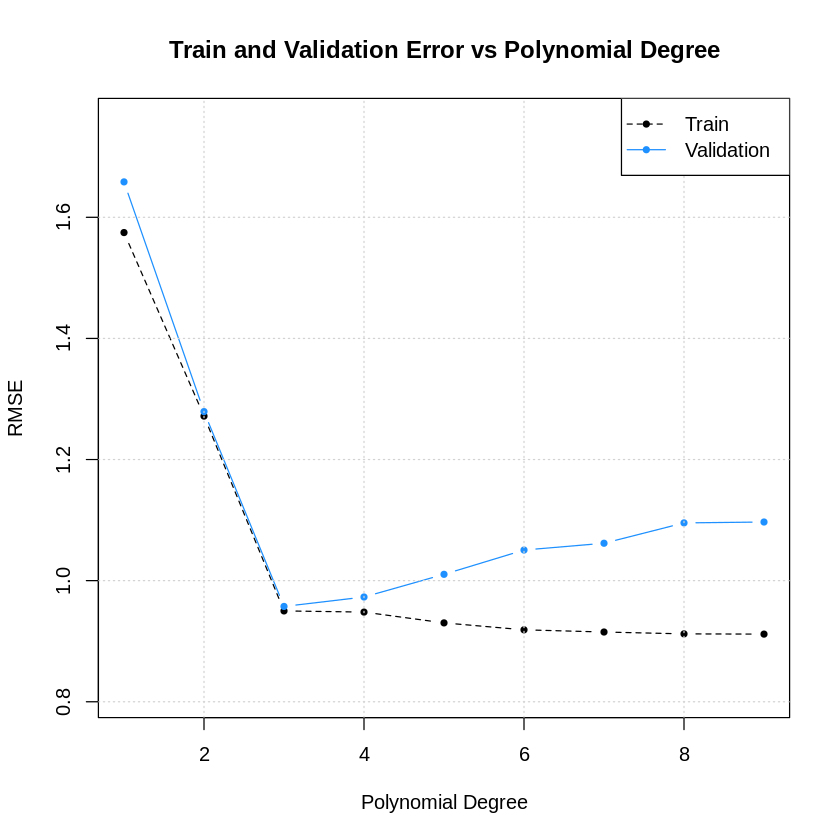

In [97]:
plot(1:9, poly_est_rmse, type = "b", pch = 20, lty = 2,
     ylim = range(c(poly_est_rmse, poly_val_rmse)) + c(-0.1, 0.1),
     xlab = "Polynomial Degree",
     ylab = "RMSE",
     main = "Train and Validation Error vs Polynomial Degree")
lines(1:9, poly_val_rmse, type = "b", col = "dodgerblue", pch = 20)
grid()
legend("topright",
  legend = c("Train", "Validation"),
  col = c("black", "dodgerblue"),
  lty = 2:1,
  pch = 20
)

What do we see here? As the polynomial degree *increases*:

- The training error *decreases*.
- The validation error *decreases*, then *increases*.
  
This more of less matches the idealized version above, but the validation "curve" is much more jagged. This is something that we can expect in practice.

We have previously noted that training error isn't particularly useful for validating models. That is still true. However, it can be useful for checking that everything is working as planned. In this case, since we known that training error decreases as model flexibility increases, we can verify our intuition that a higher degree polynomial is indeed more flexible.^[In practice, if you already know how your model's flexibility works, by checking that the training error goes down as you increase flexibility, you can check that you have done your coding and model training correctly.]

### k-Nearest Neighbors

Next up, k-nearest neighbors. We will consider values for $k$ that are odd and between $1$ and $45$ inclusive.

In [98]:
# helper function for fitting knn models
fit_knn_mod = function(neighbors) {
  knnreg(y ~ x, data = slr_est, k = neighbors)
}

In [99]:
# define values of tuning parameter k to evaluate
k_to_try = seq(from = 1, to = 45, by = 2)
# fit knn models
knn_mod_est_list = lapply(k_to_try, fit_knn_mod)

In [100]:
# make predictions on the estimation data with each model
knn_mod_est_pred = lapply(knn_mod_est_list, predict, slr_est)
# make predictions on the validation data with each model
knn_mod_val_pred = lapply(knn_mod_est_list, predict, slr_val)
# calculate train RMSE
knn_est_rmse = sapply(knn_mod_est_pred, calc_rmse, actual = slr_est$y) 
# calculate validation RMSE
knn_val_rmse = sapply(knn_mod_val_pred, calc_rmse, actual = slr_val$y) 

The plot below visualizes the results.

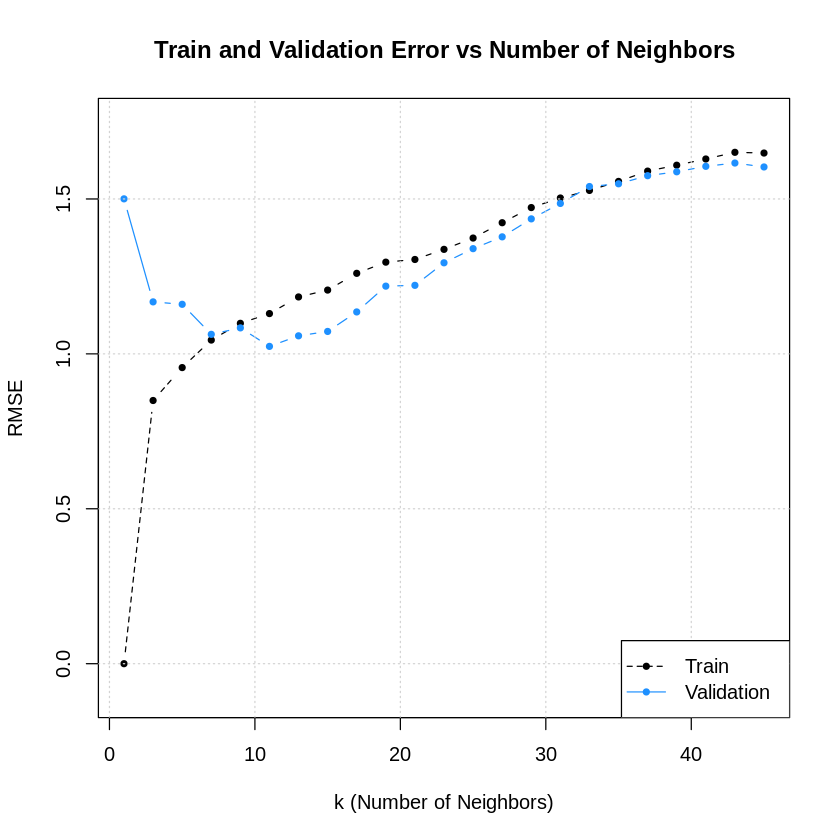

In [101]:
plot(k_to_try, knn_est_rmse, type = "b", pch = 20, lty = 2,
     ylim = range(c(knn_est_rmse, knn_val_rmse)) + c(-0.1, 0.1),
     xlab = "k (Number of Neighbors)",
     ylab = "RMSE",
     main = "Train and Validation Error vs Number of Neighbors")
lines(k_to_try, knn_val_rmse, type = "b", col = "dodgerblue", pch = 20)
grid()
legend("bottomright",
  legend = c("Train", "Validation"),
  col = c("black", "dodgerblue"),
  lty = 2:1,
  pch = 20
)

Here we see the "opposite" of the usual plot. Why? Because with k-nearest neighbors, a small value of $k$ generates a flexible model compared to larger values of $k$. So visually, this plot is flipped. That is we see that as $k$ *increases*:

- The training error *increases*.
- The validation error *decreases*, then *increases*.

Important to note here: the pattern above only holds "in general," that is, there can be minor deviations in the validation pattern along the way. This is due to the random nature of selection the data for the validate set.

### Decision Trees

Lastly, we evaluate some decision tree models. We choose some arbitrary values of `cp` to evaluate, while holding `minsplit` constant at `5`. There are arbitrary choices that produce a plot that is useful for discussion.

In [102]:
# helper function for fitting decision tree models
tree_knn_mod = function(flex) {
  rpart(y ~ x, data = slr_est, cp = flex, minsplit = 5)
}

In [103]:
# define values of tuning parameter cp to evaluate
cp_to_try = c(0.5, 0.3, 0.1, 0.05, 0.01, 0.001, 0.0001)
# fit decision tree models
tree_mod_est_list = lapply(cp_to_try, tree_knn_mod)

In [104]:
# make predictions on the estimation data with each model
tree_mod_est_pred = lapply(tree_mod_est_list, predict, slr_est)
# make predictions on the validation data with each model
tree_mod_val_pred = lapply(tree_mod_est_list, predict, slr_val)
# calculate train RMSE
tree_est_rmse = sapply(tree_mod_est_pred, calc_rmse, actual = slr_est$y) 
# calculate validation RMSE
tree_val_rmse = sapply(tree_mod_val_pred, calc_rmse, actual = slr_val$y) 

The plot below visualizes the results.

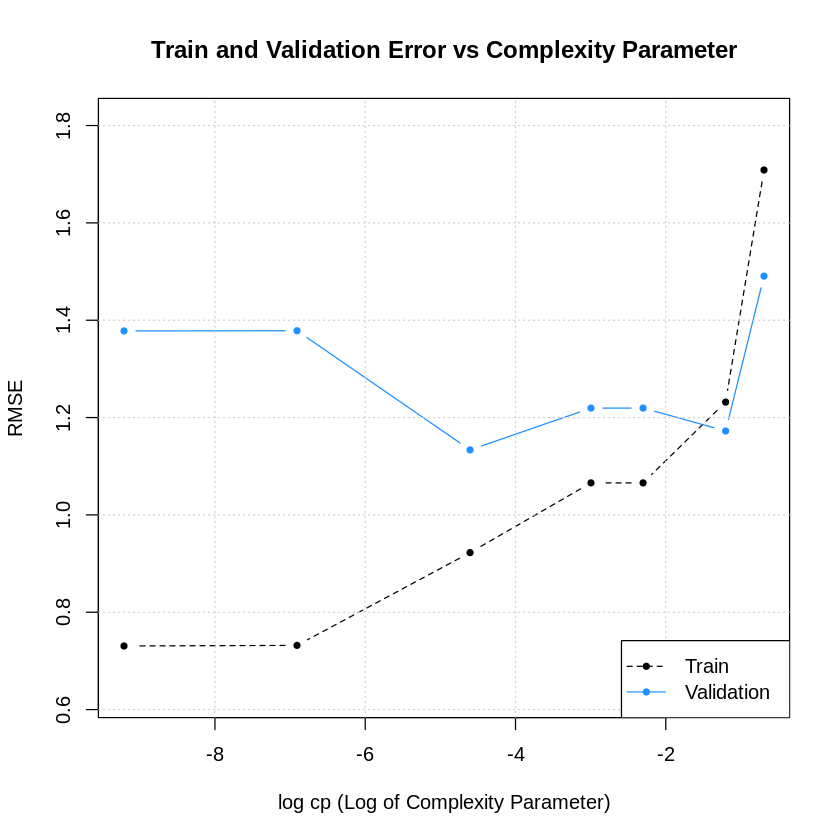

In [105]:
plot(log(cp_to_try), tree_est_rmse, type = "b", pch = 20, lty = 2,
     ylim = range(c(tree_est_rmse, tree_val_rmse)) + c(-0.1, 0.1),
     xlab = "log cp (Log of Complexity Parameter)",
     ylab = "RMSE",
     main = "Train and Validation Error vs Complexity Parameter")
lines(log(cp_to_try), tree_val_rmse, type = "b", col = "dodgerblue", pch = 20)
grid()
legend("bottomright",
  legend = c("Train", "Validation"),
  col = c("black", "dodgerblue"),
  lty = 2:1,
  pch = 20
)

Based on this plot, how is `cp` related to model flexibility?^[As `cp` increases, model flexibility decreases.]